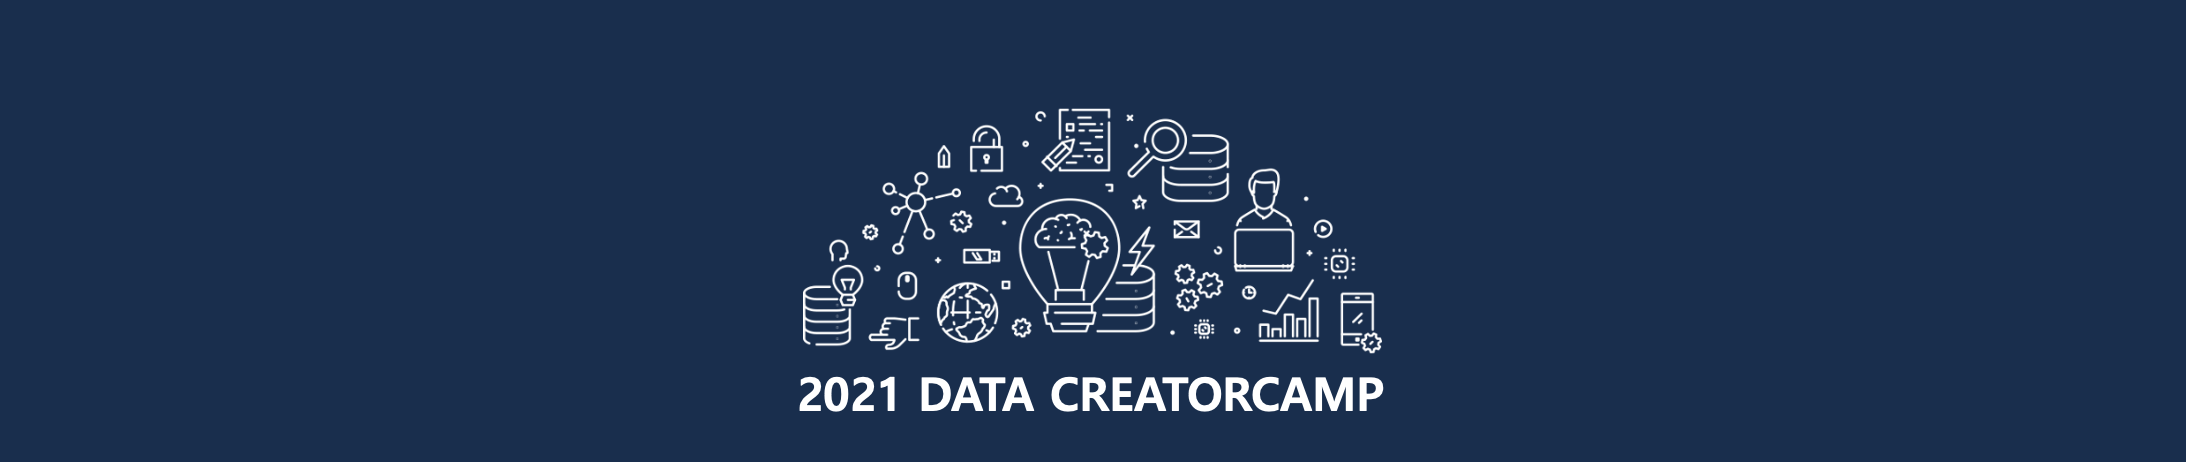

# 2021년 데이터 크리에이터 캠프 - 예선 A팀
장소 : 온라인 zoom  
날짜 : 2021년 09월 25일 (토)


### 공지(필독)
* Dataset: https://www.kaggle.com/t/1824f539250741f690862888019a60c6
* csv 파일 제출: datacreator2021a@gmail.com **(발표자료는 nia메일로 제출하셔야 합니다.)**
* 리더보드: https://github.com/Heeseung-Cho/DCC-2021-0925-A



### 문제 설명

인간 행동 인식(Human Activity Recognition)은 피실험자에게 부착된 센서로부터 받은 데이터를 분석하여 어떠한 행동을 취하고 있는지 인식하는 과제입니다. 이를 통해 로봇공학(Robotics)에서 보다 더 정교한 로봇을 만들어 낼 뿐만 아니라, 최근 AR, VR과 같은 가상환경에도 센서 값을 인식하여 가상화면에 행동을 입력할 수 있습니다.
본 과제는 군집 분석을 통해 총 561개의 센서값으로부터 받은 데이터들을 유사한 데이터들끼리 군집을 형성하고, 총 몇개의 군집으로 나타낼 수 있는지 분석해 보시길 바랍니다.

## 환경 세팅

**먼저 colab을 본인의 구글 드라이브와 연동시킵니다**

In [ ]:
#Mounting your google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**코드와 데이터가 들어 있는 폴더가 '내 드라이브'에 잘 업로드에 되어 있다면, 다음을 실행합니다**
* 먼저 내 드라이브에 '2021-data-creator-camp-0925-1' 폴더가 생성되어야 하며
* 업로드시 동일한 경로에 'baseline_cluster.ipynb', 'train.csv', 'test.csv', 'submission.csv' 파일이 함께 위치하도록 업로드합니다.

In [ ]:
cd drive/My\ Drive/2021-data-creator-camp-0925-1

[Errno 2] No such file or directory: 'drive/My Drive/2021-data-creator-camp-0925-1'
/content


### 라이브러리 가져오기

In [ ]:
# Importing important packages
## Basic
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import os
%matplotlib inline

## Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import *
from sklearn.mixture import GaussianMixture as GMM

## Torch
import torch
import torchvision
from torch import nn
import  torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import warnings 
warnings.simplefilter('ignore')

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

## 랜덤 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
random_state = 42
seed_everything(random_state)

### 데이터 가져오기

In [ ]:
# train과 test directory에 있는 data file을 각각 train/test dataframe에 할당
# dataframe 생성하는 간단한 함수 생성
train = pd.read_csv('/content/drive/MyDrive/대회/2021-data-creator-camp-0925-1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/대회/2021-data-creator-camp-0925-1/test.csv')    

### 데이터 확인하기

- 훈련 데이터(Train Data): 7352개의 레이블이 없는 센서 데이터
- 평가 데이터(Test Data): 2947개의 레이블이 없는 센서 데이터
- 피쳐 설명(Feature): 총 561개의 센서값을 나타내는 변수
- 목표: 가장 적합한 군집의 개수 찾기
- 모든 데이터의 값은 -1과 1 범위 내에서의 실수 값을 가집니다.

In [ ]:
print('## train feature dataset info()')
print(train.info())

## train feature dataset info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [ ]:
# 결측값 확인하기?
print('훈련 데이터 결측수 = {} \n테스트 데이터 결측수 = {}'.format(
              train.isnull().all().sum(),
              test.isnull().all().sum()))

훈련 데이터 결측수 = 0 
테스트 데이터 결측수 = 0


In [ ]:
## 데이터 내용 확인하기
train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.999918,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.999867,-0.991134,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.999845,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986

In [ ]:
## 데이터 통계값 확인하기
train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.842188,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001

### 데이터 전처리

In [ ]:
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train[train.columns])
test[test.columns] = scaler.fit_transform(test[test.columns])

In [ ]:
train.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.644292,0.489853,0.433547,0.002361,0.008748,0.043237,0.002444,0.008546,0.038236,0.032638,0.216311,0.127794,0.926474,0.842922,0.907131,0.017239,0.000028,0.000068,0.002694,0.002885,0.006193,0.028390,0.308519,0.160331,0.198939,0.963286,0.056701,0.679955,0.419048,0.628446,0.387576,0.632053,0.452377,0.704748,0.164601,0.747011,0.404558,0.688157,0.717565,0.828006,...,0.000041,0.004069,0.0,0.031746,0.681736,0.241960,0.09862,0.009933,0.019345,0.013173,0.025914,0.005251,0.009933,0.000380,0.003672,0.149354,0.000000,0.434799,0.805437,0.705160,0.004003,0.004651,0.005030,0.003776,0.004476,0.004003,0.000032,0.004771,0.064347,0.000000,0.475511,0.350991,0.147940,0.437030,0.515200,0.267793,0.491741,0.079377,0.798251,0.470687
1,0.639209,0.491795,0.438240,0.000877,0.012824,0.019839,0.000596,0.012749,0.021157,0.028466,0.221074,0.090796,0.924654,0.842922,0.911318,0.009035,0.000004,0.000105,0.000797,0.000425,0.011067,0.025888,0.148520,0.249535,0.214510,0.798342,0.326312,0.642107,0.607363,0.557853,0.454519,0.647155,0.359395,0.598465,0.417163,0.492359,0.389678,0.493286,0.463654,0.786728,...,0.000067,0.004184,0.0,0.079365,0.775405,0.187565,0.04992,0.005852,0.008339,0.008670,0.007426,0.004086,0.005852,0.000094,0.003011,0.139659,0.025641,0.363225,0.337016,0.143630,0.002071,0.001800,0.002279,0.001567,0.002780,0.002071,0.000010,0.002728,0.000000,0.000000,0.594891,0.201676,0.070666,0.521131,0.496283,0.133774,0.853429,0.077606,0.798487,0.472842
2,0.639827,0.490266,0.443269,0.002310,0.017058,0.010528,0.001740,0.018464,0.011266,0.030654,0.221074,0.090796,0.921804,0.841200,0.919672,0.008261,0.000015,0.000169,0.000265,0.001435,0.017595,0.012663,0.212415,0.257090,0.214510,0.622527,0.451594,0.668601,0.360755,0.508575,0.462747,0.671128,0.333718,0.682941,0.352130,0.587752,0.350254,0.437651,0.409448,0.801696,...,0.000077,0.006422,0.0,0.047619,0.840560,0.137652,0.03573,0.005373,0.006986,0.007863,0.004897,0.002149,0.005373,0.000073,0.003381,0.131739,0.102564,0.392877,0.235944,0.065707,0.002483,0.002436,0.002680,0.001970,0.002067,0.002483,0.000013,

### 차원의 저주(Curse of dimensionality)
![image info](https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile7.uf.tistory.com%2Fimage%2F99BFBF425DBFA8BC2A7DB9)

차원은 데이터가 가지고 있는 정보의 수를 나타냅니다. 일반적으로 많은 차원을 가질수록 데이터가 가진 정보가 많아진다는 장점이 있습니다. 그러나 모델의 입장에서는 일반적으로 차원이 증가할수록, 즉 feature가 많아질수록 예측 신뢰도가 떨어지고, 과적합(overfitting)이 발생하고, 개별 feature간의 상관관계가 높을 가능성이 있습니다. 그 이유로 학습을 위해서 계산해야 할 거리가 차원이 높아질 수록 멀어지고 빈공간이 증가하기 때문입니다. 이를 차원의 저주라고 합니다.

해당 데이터는 561차원의 정보를 가지고 있는, 매우 높은 차원의 데이터를 가지고 있습니다. 따라서 차원의 저주를 해결하기 위해 우리는 다음과 같은 차원 축소 방법을 이용하려고 합니다.

#### PCA

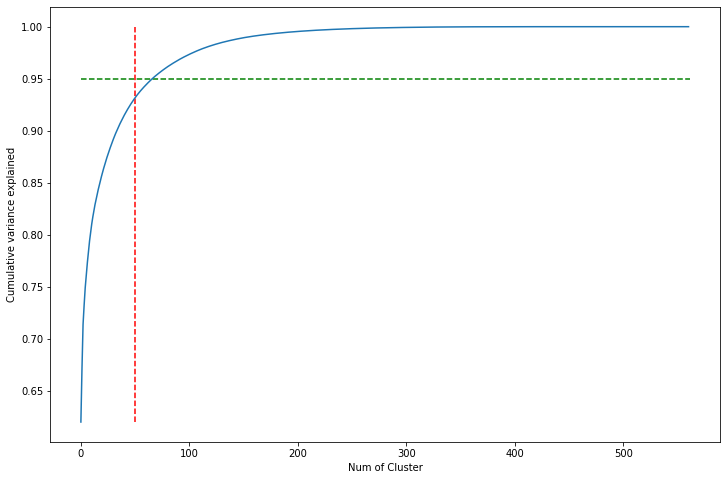

In [ ]:
n_dim = 50
# Transfom the guests
pca = PCA(random_state=random_state)
pca.fit(train)

# Lets find the total best
cum_var = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[12,8])
plt.hlines(y=0.95, xmax=len(train.columns), xmin=0, colors="g", linestyles="--")
plt.vlines(x=n_dim, ymin = np.min(cum_var), ymax = 1, colors="r", linestyles="--")
plt.plot(cum_var)
plt.ylabel("Cumulative variance explained")
plt.xlabel("Num of Cluster")
plt.show()

# Seal the Deal!    
pca_final = IncrementalPCA(n_dim)
# Transform Again
reduce_train = pca_final.fit_transform(train)
reduce_test = pca_final.fit_transform(test)

#### t-SNE

In [ ]:
n_dim = 3
tsne = TSNE(n_components=n_dim, random_state=random_state)    
reduce_train = tsne.fit_transform(train)
reduce_test = tsne.fit_transform(test)
print(reduce_test)

[[ 2.6508334  2.3982794 -2.224592 ]
 [ 5.826609   5.581699   8.007994 ]
 [14.823915  19.776348   4.981287 ]
 ...
 [-7.198435  -5.2717395 12.658195 ]
 [-7.232697  -5.430654  11.381477 ]
 [-7.352477  -5.455606  11.658863 ]]


#### Autoencoder

**Autoencoder 사용 시 GPU로 설정을 바꾸시길 바랍니다.**

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, dim):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(561, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, dim),
            nn.ReLU(inplace=True)
        ) 
        self.decoder = nn.Sequential(
            nn.Linear(dim, 256),
            nn.Linear(256,561),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def embedding(self, x):
        x = self.encoder(x)
        return x

In [ ]:
def train_ae(n_dim,train_dataloader,test_dataloader, epochs):  
    model = autoencoder(n_dim).cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)    
    num_epochs = epochs
    for epoch in range(num_epochs):
        ## ============ Train ===============
        model.train()
        train_loss = 0
        for data in train_dataloader:
            data = Variable(data).cuda()
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data)
            train_loss += loss.cpu().detach().numpy()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        ## ============ Test ===============
        model.eval()
        test_loss = 0
        for data in test_dataloader:
            data = Variable(data).cuda()
            # ===================forward=====================
            output = model(data)
            loss = criterion(output, data)
            test_loss += loss.cpu().detach().numpy()
            
        # ===================log========================
        print('epoch [{}/{}], Train loss:{:.4f}, Test loss:{:.4f}'
              .format(epoch + 1, num_epochs, train_loss/len(train_dataloader.dataset), test_loss/len(test_dataloader.dataset)))

    
    emb_train = pd.DataFrame()
    emb_test = pd.DataFrame()
    for data in train_dataloader:
        data = Variable(data).cuda()
        emb = model.embedding(data)
        emb = pd.DataFrame(emb.cpu().detach().numpy())
        emb_train = pd.concat([emb_train,emb],axis = 0, ignore_index = True)

    for data in test_dataloader:
        data = Variable(data).cuda()
        emb = model.embedding(data)
        emb = pd.DataFrame(emb.cpu().detach().numpy())
        emb_test = pd.concat([emb_test,emb],axis = 0, ignore_index = True)

    return emb_train, emb_test

In [ ]:
train_dataloader = DataLoader(torch.Tensor(train.values), batch_size=1, shuffle=True)
test_dataloader = DataLoader(torch.Tensor(test.values), batch_size=1, shuffle=False)
epochs = 50
n_dim = 150
reduce_train, reduce_test = train_ae(n_dim,train_dataloader,test_dataloader, epochs)

epoch [1/50], Train loss:0.1276, Test loss:0.1334
epoch [2/50], Train loss:0.1062, Test loss:0.1023
epoch [3/50], Train loss:0.0612, Test loss:0.0484
epoch [4/50], Train loss:0.0296, Test loss:0.0346
epoch [5/50], Train loss:0.0242, Test loss:0.0326
epoch [6/50], Train loss:0.0234, Test loss:0.0320
epoch [7/50], Train loss:0.0232, Test loss:0.0316
epoch [8/50], Train loss:0.0230, Test loss:0.0313
epoch [9/50], Train loss:0.0227, Test loss:0.0310
epoch [10/50], Train loss:0.0225, Test loss:0.0306
epoch [11/50], Train loss:0.0221, Test loss:0.0301
epoch [12/50], Train loss:0.0217, Test loss:0.0295
epoch [13/50], Train loss:0.0212, Test loss:0.0288
epoch [14/50], Train loss:0.0206, Test loss:0.0279
epoch [15/50], Train loss:0.0199, Test loss:0.0269
epoch [16/50], Train loss:0.0190, Test loss:0.0257
epoch [17/50], Train loss:0.0180, Test loss:0.0243
epoch [18/50], Train loss:0.0169, Test loss:0.0228
epoch [19/50], Train loss:0.0158, Test loss:0.0213
epoch [20/50], Train loss:0.0146, Test l

In [ ]:
reduce_train

array([[-2.78872621,  0.3062401 ,  0.7914865 , ..., -0.49565637,
         0.02182827, -0.04785902],
       [-2.78381924,  0.20949538,  0.99587169, ...,  0.06278931,
         0.24491243, -0.1203574 ],
       [-2.75339397,  0.02798966,  1.12680656, ..., -0.02736612,
         0.09955942, -0.08712741],
       ...,
       [ 2.95259869,  1.55832484, -0.51407394, ...,  0.01242572,
        -0.12484977, -0.05783559],
       [ 2.73551692,  1.73441188, -0.53382722, ..., -0.17084799,
        -0.07947403,  0.03385894],
       [ 2.77336104,  1.45665612, -0.17689606, ..., -0.18431762,
        -0.19545149, -0.19386176]])

## 모델 정의
아래는 강의에서 배운 모델들입니다. 다음 모델들을 통해 군집화를 해보시길 바랍니다.

### Kmeans


In [ ]:
kmeans_param = {
    "init":"k-means++", ## or "k-mean++"
    "max_iter":250,  ## 몇번 반복할지
    "random_state":random_state
}

### GMM

In [ ]:
gmm_param = {
    "max_iter": 400,        ## 몇번 반복할지
    "init_params":'kmeans', ## or "kmeans"
    "random_state":random_state
 } 

### DBSCAN

In [ ]:
dbscan_param = {
    "eps":0.5                 ##이웃 거리 척도
}

## 모델 평가
선택한 모델에 대해서 내부적인 평가를 진행하여 가장 최적의 군집 개수를 확인해보시길 바랍니다. 최적의 군집 개수는 어떤 전처리를 하였는가에 따라 결과가 달라지므로 이점 유의하시길 바랍니다.

#### Elbow method
Kmeans에만 적용되는 방법으로, Elbow(팔꿈치) 방법은 각 군집 별 오차제곱 합을 계산하였을 때 줄어드는 값이 급격하게 줄어드는 군집을 최적의 군집으로 판단합니다.

In [ ]:
def elbow_method(input, param):
    wcss = []
    for i in range(2, 20):
        km = KMeans(n_clusters = i, **param)
        km.fit(input)
        wcss.append(km.inertia_)
    plt.figure(figsize=(16,10))    
    plt.plot(range(2, 20), wcss)
    plt.title('The Elbow Method', fontsize = 20)
    plt.xlabel('No. of Clusters')
    plt.ylabel('wcss')
    plt.show()
    

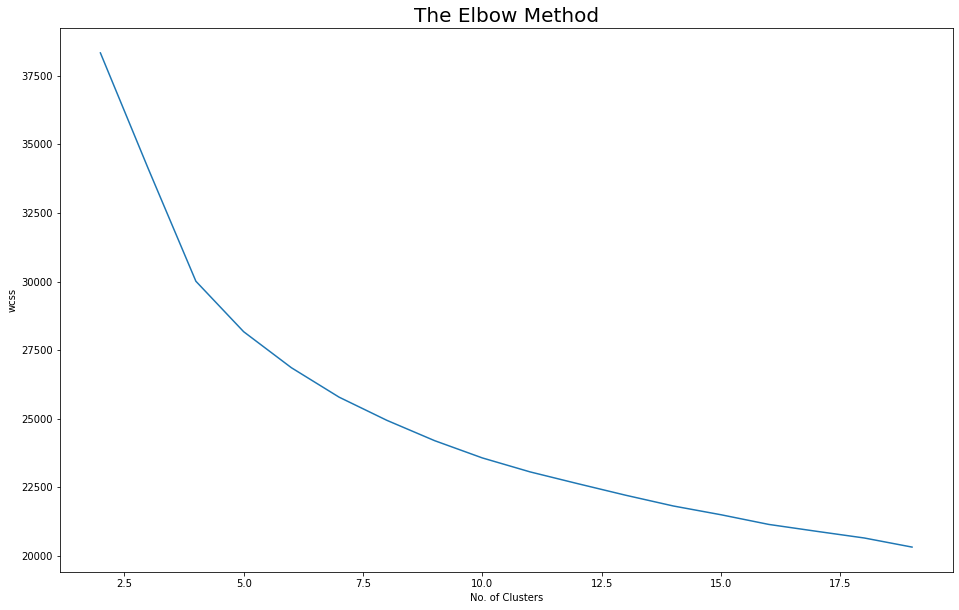

In [ ]:
elbow_method(input = reduce_train,
             param = kmeans_param)

#### Silhouette method

Silhouette(실루엣) 값이란 내부적으로 군집 내에서 일관성의 해석 및 유효성 검사 방법을 나타냅니다.  값은 객체가 다른 클러스터와 비교하여 자체 클러스터와 얼마나 유사한 지 측정합니다. Silhouette 값은 -1과 1 사이의 값을 가지며, 높을 수록 군집이 잘 되있다고 볼 수 있습니다.

Silhouette method을 통하여 현재 데이터와 파라미터 상에서 최적의 군집을 확인해보시길 바랍니다.

In [ ]:
def silhouette_method(model, input, param):
    if model.lower() == "kmeans":
      clusters_per_k = [KMeans(n_clusters = k, **param).fit(input) for k in range(1,20)]
      silhouette_scores =[silhouette_score(input, model.labels_) for model in clusters_per_k[1:]]
      title = "Silhouette Curve for optimal number of clusters"
    elif model.lower() == "gmm":
      clusters_per_k = [GMM(n_components = k, **param).fit(input) for k in range(1,20)]
      silhouette_scores =[silhouette_score(input, model.predict(input)) for model in clusters_per_k[1:]]
      title = "Silhouette Curve for optimal number of clusters"
    elif model.lower() == "dbscan":
      clusters_per_k = [DBSCAN(min_samples= k, **param).fit(input) for k in range(1,20)]
      silhouette_scores =[silhouette_score(input, model.labels_) if len(np.unique(model.labels_)) > 1 else -1 for model in clusters_per_k[1:]]
      title = "Silhouette Curve for optimal number of min_sample"
      
    else:
      print("모델이 올바르지 않습니다.")
      return

    plt.figure(figsize=(12,8))
    plt.plot(range(2,20), silhouette_scores,"bo-", color="black", label='Silhouette Curve')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Curve")
    plt.grid(linestyle='--')
    plt.title("Silhouette Curve for optimal parameters")

    k = np.argmax(silhouette_scores)+2

    plt.axvline(x=k, c="yellow", linestyle='--', linewidth=3, label='Optimal number of clusters({})'.format(k))
    plt.scatter(k, silhouette_scores[k-2], s=400)
    plt.legend(shadow=True)

    plt.show()

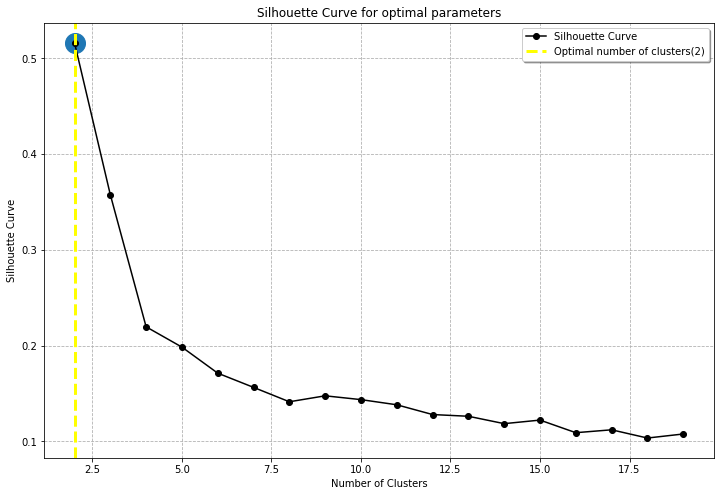

In [ ]:
silhouette_method(model = "KMeans", ## "KMeans", "GMM", "DBSCAN"
                  input = reduce_train,
                  param = kmeans_param) ## 모델에 맞는 파라미터 사용

### Set Model & Train

In [ ]:
K = 4 ## 위의 결과, 혹은 다른 값을 이용
model = KMeans(n_clusters= K, **kmeans_param).fit(reduce_train)
#model = GMM(n_components= K, **gmm_param).fit(train)
#model = DBSCAN(min_samples= K, **dbscan_param)

In [ ]:
## 훈련 결과
train_cluster = model.predict(reduce_train)
test_cluster = model.predict(reduce_test)

In [ ]:
## DBSCAN의 경우, train 데이터와 test 데이터를 별개로 학습
train_cluster = model.fit_predict(reduce_train)
test_cluster = model.fit_predict(reduce_test)

### 시각화 확인


In [ ]:
tsne = TSNE(n_components=3, random_state=random_state)
projections = tsne.fit_transform(train)

In [ ]:
print("군집 완료, 시각적으로 확인해보세요.")
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=train_cluster, labels={'color': 'cluster'}
)
fig.update_traces(marker_size=8)
fig.show()

#submission = pd.read_csv('submission.csv')
#submission['group'] = test_cluster
#submission.index = submission['index']
#submission = submission.drop(['index'], axis = 1)

군집 완료, 시각적으로 확인해보세요.


### 결과 제출

In [ ]:
from datetime import datetime

# 제출 파일 만들기
team="우물안개구리5"# 반드시 팀명을 적어주세요.
#이밑은 수정하지 마세요.
timestamp = datetime.today().strftime("%Y%m%d%H%M%S") # ex) timestamp 20210925131000 sub = pd.DataFrame(y_pred, columns=["y_pred"])
submission.to_csv(f"./{team}_{timestamp}.csv", index=False, encoding='utf8')

In [ ]:
submission

,group
index,
0,1
1,1
2,1
3,1
4,1
...,...
2942,0
2943,0
2944,0
